--- 1. Data Processing (Oscillators + ADX) ---
--- 2. Setting up 8 Parallel PPO Environments ---
Using cpu device
--- 3. Training (100000 steps) ---
------------------------------
| time/              |       |
|    fps             | 23340 |
|    iterations      | 1     |
|    time_elapsed    | 0     |
|    total_timesteps | 2048  |
------------------------------


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_71803/1734348943.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_71803/1734348943.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc_data = yf.download(CONFIG['TARGET_ASSET'], start=self.start_date, end=self.end_date, progress=False)


------------------------------------------
| time/                   |              |
|    fps                  | 9599         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0037418692 |
|    clip_fraction        | 0.0133       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.0519      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.1          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00585     |
|    std                  | 1            |
|    value_loss           | 2.68         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 8333         |
|    iterations           | 3            |
|    time_e

/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_71803/1734348943.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)



MEAN REVERSION REPORT (IWM)
Metric               | Value          
----------------------------------------
Total Return         |      11.07%
Final Balance        | $111,066.21
Sharpe Ratio         |        1.27
Max Drawdown         |      -6.59%
Total Trades         |         182
Win Rate (Days)      |      53.02%
----------------------------------------


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_71803/1734348943.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc_data = yf.download(CONFIG['TARGET_ASSET'], start=self.start_date, end=self.end_date, progress=False)


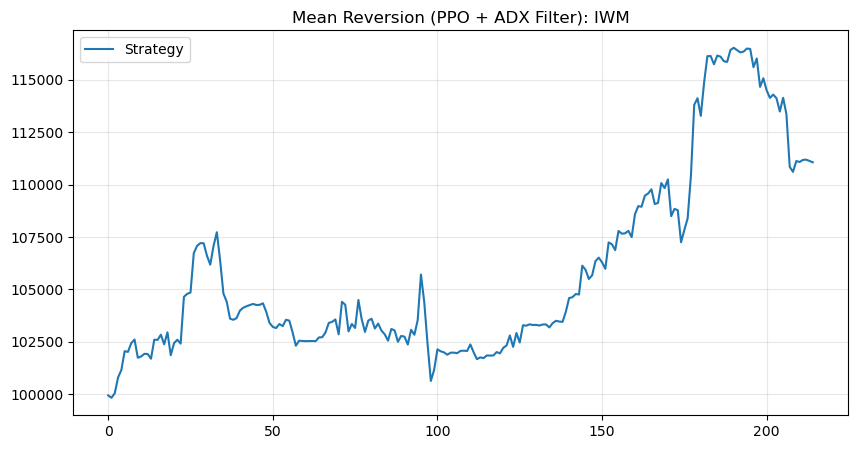

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION (SCALPER PROFILE)
# ==========================================
CONFIG = {
    "TICKERS": ["IWM", "^VIX"], # Russell 2000 (Small Caps) + VIX
    "TARGET_ASSET": "IWM",
    "START_DATE": "2015-01-01",
    "END_DATE": "2023-12-31",
    "TEST_START_DATE": "2024-01-02",
    
    # Feature Engineering
    "WINDOW_SIZE": 10,         
    "BB_STD": 2.0,             
    
    # RL Environment
    "INITIAL_BALANCE": 100000,
    "TRADING_FEES": 0.0005,    # 5 bps
    
    # Reward
    "REWARD_SCALING": 100.0,   
    
    # PPO Settings (Optimized for Speed)
    "LEARNING_RATE": 3e-4,     
    "BATCH_SIZE": 256,         # Larger batch size for efficiency
    "ENT_COEF": 0.01,          
    "TRAINING_TIMESTEPS": 100000,
    "N_ENVS": 8                # Parallel environments for faster collection
}

# ==========================================
# 2. MEAN REVERSION DATA PIPELINE
# ==========================================
class DataProcessor:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        
    def download_data(self):
        print(f"Downloading data for {self.tickers}...")
        try:
            data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
            if data.empty: return pd.DataFrame()

            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]:
                    data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]:
                    data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]:
                    data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series): data = data.to_frame()
            
            # Re-fetch for OHLC (ADX calc)
            ohlc_data = yf.download(CONFIG['TARGET_ASSET'], start=self.start_date, end=self.end_date, progress=False)
            
            return data, ohlc_data
            
        except Exception as e:
            print(f"Error during download: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def calculate_adx(self, df, window=14):
        df = df.copy()
        df['tr0'] = abs(df['High'] - df['Low'])
        df['tr1'] = abs(df['High'] - df['Close'].shift(1))
        df['tr2'] = abs(df['Low'] - df['Close'].shift(1))
        df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
        
        df['dir_plus'] = df['High'] - df['High'].shift(1)
        df['dir_minus'] = df['Low'].shift(1) - df['Low']
        
        df['dm_plus'] = np.where((df['dir_plus'] > df['dir_minus']) & (df['dir_plus'] > 0), df['dir_plus'], 0)
        df['dm_minus'] = np.where((df['dir_minus'] > df['dir_plus']) & (df['dir_minus'] > 0), df['dir_minus'], 0)
        
        # Smoothed
        df['tr_smooth'] = df['tr'].rolling(window).mean()
        df['dm_plus_smooth'] = df['dm_plus'].rolling(window).mean()
        df['dm_minus_smooth'] = df['dm_minus'].rolling(window).mean()
        
        df['di_plus'] = (df['dm_plus_smooth'] / (df['tr_smooth'] + 1e-8)) * 100
        df['di_minus'] = (df['dm_minus_smooth'] / (df['tr_smooth'] + 1e-8)) * 100
        
        df['dx'] = (abs(df['di_plus'] - df['di_minus']) / (abs(df['di_plus'] + df['di_minus']) + 1e-8)) * 100
        df['adx'] = df['dx'].rolling(window).mean()
        
        return df['adx']

    def add_indicators(self, close_df, ohlc_df, target_ticker):
        if close_df.empty: return pd.DataFrame()
        df = close_df.copy()
        
        # 1. Bollinger Bands
        sma = df[target_ticker].rolling(window=20).mean()
        std = df[target_ticker].rolling(window=20).std()
        df['bb_upper'] = sma + (std * CONFIG['BB_STD'])
        df['bb_lower'] = sma - (std * CONFIG['BB_STD'])
        
        df['pct_b'] = (df[target_ticker] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / sma
        
        # 2. RSI
        delta = df[target_ticker].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # 3. Distance from MA
        df['dist_ma'] = (df[target_ticker] - sma) / (std + 1e-8)
        
        # 4. ADX (Trend Strength)
        if not ohlc_df.empty:
            adx_series = self.calculate_adx(ohlc_df)
            df['adx'] = adx_series
        else:
            df['adx'] = 0
        
        df['returns'] = df[target_ticker].pct_change()
        df.dropna(inplace=True)
        return df

    def get_processed_data(self, target_ticker):
        close_df, ohlc_df = self.download_data()
        if close_df.empty: return pd.DataFrame()
        
        df = self.add_indicators(close_df, ohlc_df, target_ticker)
        
        # Ensure 'returns' and 'adx' are included and identifiable
        features = ['returns', 'pct_b', 'bb_width', 'rsi', 'adx', 'dist_ma']
        return df[features].fillna(0)

# ==========================================
# 3. SCALPING ENVIRONMENT (OPTIMIZED)
# ==========================================
class MeanReversionEnv(gym.Env):
    def __init__(self, df, config):
        super(MeanReversionEnv, self).__init__()
        # Optimization: Convert DataFrame to Numpy Array for fast step() access
        self.data_matrix = df.values.astype(np.float32)
        self.feature_cols = df.columns.tolist()
        
        # Pre-calculate column indices for fast lookup
        self.ret_col_idx = self.feature_cols.index('returns')
        self.adx_col_idx = self.feature_cols.index('adx')
        
        self.config = config
        self.window_size = config['WINDOW_SIZE']
        self.n_features = df.shape[1]
        self.data_len = len(df)
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.window_size * self.n_features,), 
            dtype=np.float32
        )
        
        self.current_step = self.window_size
        self.balance = config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []
        return self._get_observation(), {}

    def _get_observation(self):
        # Direct numpy slicing (Faster than iloc)
        obs = self.data_matrix[self.current_step - self.window_size : self.current_step]
        return obs.flatten()

    def step(self, action):
        raw_action = np.clip(action, -1, 1)[0]
        
        if self.current_step >= self.data_len:
            return self._get_observation(), 0, True, False, {}
            
        # Fast access using pre-calculated indices
        adx = self.data_matrix[self.current_step, self.adx_col_idx]
        market_return = self.data_matrix[self.current_step, self.ret_col_idx]
        
        # DYNAMIC ACTION SCALING
        scaling_factor = 1.0
        if adx > 25: scaling_factor = 0.5
        if adx > 40: scaling_factor = 0.1
            
        executed_action = raw_action * scaling_factor
            
        # Cost Calculation
        prev_action = self.history[-1]['action'] if len(self.history) > 0 else 0
        turnover = abs(executed_action - prev_action)
        cost = turnover * self.config['TRADING_FEES']
        
        strategy_return = (executed_action * market_return) - cost
        self.portfolio_value *= (1 + strategy_return)
        
        # Reward
        reward = strategy_return * self.config['REWARD_SCALING']

        self.current_step += 1
        terminated = self.current_step >= self.data_len - 1
        
        info = {
            'portfolio_value': self.portfolio_value,
            'return': strategy_return,
            'action': executed_action,
            'turnover': turnover
        }
        self.history.append(info)
        
        return self._get_observation(), reward, terminated, False, info

# ==========================================
# 4. EXECUTION & REPORTING
# ==========================================
def calculate_metrics(returns):
    if len(returns) < 2: return 0, 0
    sharpe = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(252)
    cum_returns = (1 + returns).cumprod()
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    return sharpe, drawdown.min()

def run_mean_reversion():
    print("--- 1. Data Processing (Oscillators + ADX) ---")
    data_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['START_DATE'], CONFIG['END_DATE'])
    train_df = data_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if train_df.empty: return

    print(f"--- 2. Setting up {CONFIG['N_ENVS']} Parallel PPO Environments ---")
    # Vectorized Environment for Speed (Run N environments in parallel)
    env = DummyVecEnv([lambda: MeanReversionEnv(train_df, CONFIG) for _ in range(CONFIG['N_ENVS'])])
    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)
    
    model = PPO(
        "MlpPolicy", 
        env, 
        verbose=1,
        learning_rate=CONFIG['LEARNING_RATE'],
        # Divide steps by N_ENVS to maintain similar update frequency
        n_steps=2048 // CONFIG['N_ENVS'], 
        batch_size=CONFIG['BATCH_SIZE'],
        ent_coef=CONFIG['ENT_COEF']
    )
    
    print(f"--- 3. Training ({CONFIG['TRAINING_TIMESTEPS']} steps) ---")
    model.learn(total_timesteps=CONFIG['TRAINING_TIMESTEPS'])
    
    print("--- 4. Backtesting ---")
    test_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['TEST_START_DATE'], "2025-01-01")
    test_df = test_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if test_df.empty: return

    test_env = DummyVecEnv([lambda: MeanReversionEnv(test_df, CONFIG)])
    test_env = VecNormalize(test_env, norm_obs=True, norm_reward=False, clip_obs=10.)
    test_env.obs_rms = env.obs_rms 
    test_env.training = False
    
    obs = test_env.reset()
    history = []
    
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done_array, info_array = test_env.step(action)
        history.append(info_array[0])
        if done_array[0]: break
        
    # --- DETAILED ANALYSIS ---
    res = pd.DataFrame(history)
    
    strat_ret = res['return']
    total_ret = (res['portfolio_value'].iloc[-1] / CONFIG['INITIAL_BALANCE']) - 1
    sharpe, mdd = calculate_metrics(strat_ret)
    
    trades = (res['turnover'] > 0.01).sum()
    win_rate = (strat_ret > 0).mean()
    
    print("\n" + "="*50)
    print(f"MEAN REVERSION REPORT ({CONFIG['TARGET_ASSET']})")
    print("="*50)
    print(f"{'Metric':<20} | {'Value':<15}")
    print("-" * 40)
    print(f"{'Total Return':<20} | {total_ret:>11.2%}")
    print(f"{'Final Balance':<20} | ${res['portfolio_value'].iloc[-1]:,.2f}")
    print(f"{'Sharpe Ratio':<20} | {sharpe:>11.2f}")
    print(f"{'Max Drawdown':<20} | {mdd:>11.2%}")
    print(f"{'Total Trades':<20} | {trades:>11}")
    print(f"{'Win Rate (Days)':<20} | {win_rate:>11.2%}")
    print("-" * 40)
    
    plt.figure(figsize=(10, 5))
    plt.plot(res['portfolio_value'], label='Strategy')
    plt.title(f"Mean Reversion (PPO + ADX Filter): {CONFIG['TARGET_ASSET']}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    torch.set_num_threads(4)
    run_mean_reversion()